In [ ]:
# !pip install xgboost

     -------------------------------------- 150.0/150.0 MB 7.0 MB/s eta 0:00:00


In [ ]:
# !pip install shap

     ------------------------------------- 489.6/489.6 kB 10.2 MB/s eta 0:00:00


In [ ]:
# ! pip install optuna

     -------------------------------------- 386.6/386.6 kB 6.0 MB/s eta 0:00:00


In [ ]:
# !pip install -U kaleido

     --------------------------------------- 65.9/65.9 MB 16.0 MB/s eta 0:00:00


## 00.Pacotes

In [ ]:
import pandas as pd
import numpy as np
import funcoes_basicas as funcs
import funcoes_derivadas as funcs_deriv
import random
import gc

import matplotlib.pyplot as plt
import itertools

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, balanced_accuracy_score, classification_report, confusion_matrix, roc_curve, precision_recall_curve

# Filter out the ConvergenceWarning
from sklearn.exceptions import ConvergenceWarning

from datetime import date, datetime
from tqdm import tqdm
from scipy.stats import ks_2samp

import xgboost as xgb
import optuna
import pickle
import shap

from joblib import dump, load

def ks_stat(y, y_pred):
    return ks_2samp(y_pred[y == 1], y_pred[y != 1]).statistic

ks_score = make_scorer(ks_stat)

# Definindo a semente
random.seed(123)

import warnings
warnings.filterwarnings("ignore")
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## 01. Baixando a base

In [ ]:
# Baixando os dados de treino
df_treino = pd.read_parquet(r'D:\projeto_modelo_credito\dados\df_treino_processado.parquet',
                                 engine='pyarrow')

df_treino.head()

,SK_ID_CURR,TARGET_publico,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__EXT_SOURCE_1_publico,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,...,num__INCOME_TO_BIRTH_RATIO_publico,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico
0,100010,0,0.540654,0.714279,-999.000000,0.03,1530000.0,-449.0,-18850.0,-999.0,...,-19.10,-999.0,-999.0,0.0,0.0,0.0,-999.0,1.0,0.0,1.0
1,100263,0,0.270707,0.235314,0.770814,0.06,585000.0,365243.0,-23456.0,133240.5,...,-4.60,-999.0,-999.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,100320,0,-999.000000,0.610447,-999.000000,0.10,463500.0,-2907.0,-11996.0,-999.0,...,-18.76,-999.0,-999.0,0.0,0.0,-999.0,0.0,1.0,0.0,0.0
3,100704,0,0.621226,0.398296,0.676170,0.03,760500.0,-7042.0,-17781.0,29682.0,...,-5.06,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,1.0
4,100768,0,0.556727,0.639849,0.722559,0.04,229500.0,-2271.0,-20438.0,-999.0,...,-5.50,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,0.0


In [ ]:
# Baixando os dados de teste
df_teste = pd.read_parquet(r'D:\projeto_modelo_credito\dados\df_teste_processado.parquet',
                                 engine='pyarrow')
df_teste.head()

,SK_ID_CURR,TARGET_publico,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__EXT_SOURCE_1_publico,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,...,num__INCOME_TO_BIRTH_RATIO_publico,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico
0,101122,0,0.605836,0.347977,-999.000000,0.04,517500.0,-2058.0,-12198.0,-999.0,...,-7.38,-999.0000,-999.0,0.0,1.0,-999.0,0.0,0.0,0.0,0.0
1,102745,0,0.357293,0.591461,0.336847,0.04,607500.0,-2024.0,-17131.0,313573.5,...,-11.82,-999.0000,-999.0,0.0,0.0,-999.0,0.0,0.0,0.0,1.0
2,103634,0,0.584990,0.707927,-999.000000,0.03,1125000.0,-3391.0,-17445.0,-999.0,...,-16.77,-999.0000,-999.0,0.0,0.0,-999.0,0.0,0.0,0.0,1.0
3,104454,0,0.519097,-999.000000,-999.000000,0.11,58500.0,-5093.0,-13772.0,0.0,...,-7.35,0.0154,-999.0,0.0,0.0,-999.0,0.0,0.0,0.0,0.0
4,104665,0,0.495666,0.303363,0.285083,0.05,900000.0,-191.0,-9269.0,-999.0,...,-19.42,0.1026,-999.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0


In [ ]:
# Substiruir o nome da coluna do target

df_treino = df_treino.rename(columns={"TARGET_publico": "TARGET"})
df_teste = df_teste.rename(columns={"TARGET_publico": "TARGET"})

### 02. Concatenando os dados de treino e teste

In [ ]:
# Adiciona a coluna 'periodo' em cada DataFrame
df_treino['periodo'] = 'treino'
df_teste['periodo'] = 'teste'

# Concatena os dois
df_final_marcado = pd.concat([df_treino, df_teste], ignore_index=True)
df_final_marcado.shape

(184350, 44)

In [ ]:
df_final_marcado.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__EXT_SOURCE_1_publico,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,...,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico,periodo
0,100010,0,0.540654,0.714279,-999.000000,0.03,1530000.0,-449.0,-18850.0,-999.0,...,-999.0,-999.0,0.0,0.0,0.0,-999.0,1.0,0.0,1.0,treino
1,100263,0,0.270707,0.235314,0.770814,0.06,585000.0,365243.0,-23456.0,133240.5,...,-999.0,-999.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,treino
2,100320,0,-999.000000,0.610447,-999.000000,0.10,463500.0,-2907.0,-11996.0,-999.0,...,-999.0,-999.0,0.0,0.0,-999.0,0.0,1.0,0.0,0.0,treino
3,100704,0,0.621226,0.398296,0.676170,0.03,760500.0,-7042.0,-17781.0,29682.0,...,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,1.0,treino
4,100768,0,0.556727,0.639849,0.722559,0.04,229500.0,-2271.0,-20438.0,-999.0,...,-999.0,-999.0,1.0,0.0,-999.0,0.0,1.0,0.0,0.0,treino


In [ ]:
# Verificando duplicados
df_final_marcado[df_final_marcado.duplicated(subset='SK_ID_CURR', keep=False)]

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__EXT_SOURCE_1_publico,num__PAYMENT_RATE_publico,num__AMT_GOODS_PRICE_publico,num__DAYS_EMPLOYED_publico,num__DAYS_BIRTH_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,...,num__LIVINGAPARTMENTS_MEDI_publico,num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,cat__WALLSMATERIAL_MODE_publico_Panel,num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,cat__NAME_CONTRACT_TYPE_publico_Cash_loans,num__FLAG_DOCUMENT_6_publico,num__FLAG_WORK_PHONE_publico,periodo


In [ ]:
# Verificando a volumetria do Target (Bad Rate)
contagem = df_final_marcado['TARGET'].value_counts()
percentual = df_final_marcado['TARGET'].value_counts(normalize=True) * 100

df_resultado = pd.DataFrame({'Total': contagem, 'Porcentagem': round(percentual, 2)})
df_resultado


,Total,Porcentagem
TARGET,,
0,170074,92.26
1,14276,7.74


## 03. Seleção de variáveis

### 03.01.  Ajustando o formato das variáveis

In [ ]:
#2- Separarando as variáveis por tipo
# Separando as variáveis por tipo: categórica, numérica e algumas que possam ter erro
# tirando as 2 primeiras variáveis 'SK_ID_CURR' e 'TARGET'
vars = df_final_marcado.columns[2:-1].tolist()

lista_vars_num = []
lista_vars_categ = []
lista_vars_erro = []

for var in vars:
    tipo_coluna = df_final_marcado[var].dtype
    if tipo_coluna.name in (['Int32', 'Int64', 'int32', 'int64', 'Float32', 'Float64', 'float32', 'float64']):
        lista_vars_num.append(var)
    elif tipo_coluna.name in (['object', 'string', 'category']):
        lista_vars_categ.append(var)
    else:
        lista_vars_erro.append(var)

print(f'lista_vars_num: {len(lista_vars_num)}')
print()
print(f'lista_vars_categ: {len(lista_vars_categ)}')
print()
print(f'lista_vars_erro: {len(lista_vars_erro)}')


lista_vars_num: 41

lista_vars_categ: 0

lista_vars_erro: 0


In [ ]:
vars_lista = df_final_marcado.columns.tolist()
vars_lista

['SK_ID_CURR',
 'TARGET',
 'num__EXT_SOURCE_3_publico',
 'num__EXT_SOURCE_2_publico',
 'num__EXT_SOURCE_1_publico',
 'num__PAYMENT_RATE_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__VL_TOT_VL_TOT_AM

In [ ]:
vars_pre_sel = [
 'num__EXT_SOURCE_3_publico',
 'num__EXT_SOURCE_2_publico',
 'num__EXT_SOURCE_1_publico',
 'num__PAYMENT_RATE_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
 'num__TOTALAREA_MODE_publico',
 'num__REGION_POPULATION_RELATIVE_publico',
 'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
 'num__DAYS_ID_PUBLISH_publico',
 'num__CAR_TO_EMPLOYED_RATIO_publico',
 'num__REG_CITY_NOT_WORK_CITY_publico',
 'num__FLAG_DOCUMENT_3_publico',
 'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__DAYS_REGISTRATION_publico',
 'cat__OCCUPATION_TYPE_publico_Laborers',
 'num__INCOME_TO_BIRTH_RATIO_publico',
 'num__LIVINGAPARTMENTS_MEDI_publico',
 'num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo',
 'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
 'cat__WALLSMATERIAL_MODE_publico_Panel',
 'num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo',
 'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
 'cat__NAME_CONTRACT_TYPE_publico_Cash_loans',
 'num__FLAG_DOCUMENT_6_publico',
 'num__FLAG_WORK_PHONE_publico']

### 03.02. Univariada

In [ ]:
## Calcula a univariada das variáveis já considerando a imputação de missing = -999

univariada_v2 = funcs.univariada_numerica_v2(df_final_marcado, vars_pre_sel)
univariada_v2

,var,tamanho df,tamanho var,% missing,mean,std,min,max,P1,P5,P10,P25,P50,P75,P90,P95,P99
0,num__EXT_SOURCE_3_publico,184350,171508,0.069661,0.509984,1.942848e-01,5.272652e-04,8.960096e-01,0.064672,0.154744,0.227613,0.370650,0.535276,0.665855,7.490217e-01,7.850520e-01,8.327850e-01
1,num__EXT_SOURCE_2_publico,184350,183971,0.002056,0.517304,1.896652e-01,1.315956e-06,8.549997e-01,0.030540,0.137149,0.222426,0.398428,0.568661,0.665014,7.226300e-01,7.479548e-01,7.829757e-01
2,num__EXT_SOURCE_1_publico,184350,81891,0.555785,0.506871,2.096912e-01,1.456813e-02,9.516240e-01,0.086590,0.162806,0.218007,0.340340,0.512329,0.678773,7.879463e-01,8.332641e-01,8.898526e-01
3,num__PAYMENT_RATE_publico,184350,184342,0.000043,0.053303,2.253779e-02,2.000000e-02,1.200000e-01,0.030000,0.030000,0.030000,0.040000,0.050000,0.060000,9.000000e-02,1.000000e-01,1.100000e-01
4,num__AMT_GOODS_PRICE_publico,184350,184185,0.000895,545463.313511,3.714839e+05,4.050000e+04,4.050000e+06,67500.000000,135000.000000,180000.000000,238500.000000,450000.000000,688500.000000,1.125000e+06,1.327500e+06,1.800000e+06
5,num__DAYS_EMPLOYED_publico,184350,184293,0.000309,63078.003261,1.407314e+05,-1.791200e+04,3.652430e+05,-11008.080000,-6928.000000,-5006.000000,-2850.000000,-1269.000000,-308.000000,3.652430e+05,3.652430e+05,3.652430e+05
6,num__DAYS_BIRTH_publico,184350,184350,0.000000,-16094.297662,4.307276e+03,-2.520100e+04,-7.489000e+03,-24387.000000,-23178.000000,-22144.000000,-19692.000000,-15797.000000,-12545.000000,-1.040800e+04,-9.599000e+03,-8.357000e+03
7,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS...,184350,97151,0.473008,528652.758169,1.281379e+06,-6.795000e+04,6.457024e+07,0.000000,0.000000,0.000000,36805.500000,153810.000000,514818.265625,1.285898e+06,2.118843e+06,5.853931e+06
8,num__CREDIT_TO_GOODS_RATIO_publico,184350,184185,0.000895,1.123439,1.241990e-01,1.500000e-01,6.000000e+00,1.000000,1.000000,1.000000,1.000000,1.120000,1.200000,1.280000e+00,1.400000e+00,1.480000e+00
9,num__INCOME_TO_EMPLOYED_RATIO_publico,184350,184348,0.000011,-175.074856,7.193512e+02,-2.137500e+05,6.160000e+00,-1548.170044,-703.130005,-416.670013,-173.880005,-70.720001,-23.670000,3.100000e-01,4.300000e-01,7.400000e-01


In [ ]:
univariada_v2.to_excel('univariada_xgboost.xlsx')

### 03.03. Calculando o IV e KS

In [ ]:
pd.set_option('display.max_rows', None)     # Mostra todas as linhas
pd.set_option('display.max_columns', None)  # Mostra todas as colunas
pd.set_option('display.width', None)        # Não quebra a linha
pd.set_option('display.max_colwidth', None) # Mostra o conteúdo completo das células

# Calcula IV e KS

tabela_iv_ks, tabela_iv_ks_completa = funcs.calcular_iv_ks_woe(
    dados=df_final_marcado,
    variaveis=vars_pre_sel,
    target='TARGET',
    chave='SK_ID_CURR',
    bins=10,
    exibir_woe=False,
    ordenacao=['IV', 'KS']
)

tabela_iv_ks

Calculando IV/KS/WOE: 100%|████████████████████████████████████████████████████████████| 41/41 [00:21<00:00,  1.86it/s]


,Variavel,IV,KS
0,num__EXT_SOURCE_3_publico,0.328,0.253
1,num__EXT_SOURCE_2_publico,0.277,0.212
2,num__PAYMENT_RATE_publico,0.105,0.096
3,num__EXT_SOURCE_1_publico,0.105,0.117
4,num__AMT_GOODS_PRICE_publico,0.100,0.092
5,num__DAYS_EMPLOYED_publico,0.098,0.083
6,num__DAYS_BIRTH_publico,0.082,0.117
7,num__CREDIT_TO_GOODS_RATIO_publico,0.077,0.122
8,num__INCOME_TO_EMPLOYED_RATIO_publico,0.076,0.122
9,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,0.075,0.132


In [ ]:
# Filtrando as variáveis com valore de IV >= 0.01
tabela_iv_ks_filtrado = tabela_iv_ks[
    (tabela_iv_ks['Variavel'].isin(vars_pre_sel)) & (tabela_iv_ks['IV'] >= 0.01)
].reset_index(drop=True)

tabela_iv_ks_filtrado

,Variavel,IV,KS
0,num__EXT_SOURCE_3_publico,0.328,0.253
1,num__EXT_SOURCE_2_publico,0.277,0.212
2,num__PAYMENT_RATE_publico,0.105,0.096
3,num__EXT_SOURCE_1_publico,0.105,0.117
4,num__AMT_GOODS_PRICE_publico,0.100,0.092
5,num__DAYS_EMPLOYED_publico,0.098,0.083
6,num__DAYS_BIRTH_publico,0.082,0.117
7,num__CREDIT_TO_GOODS_RATIO_publico,0.077,0.122
8,num__INCOME_TO_EMPLOYED_RATIO_publico,0.076,0.122
9,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,0.075,0.132


In [ ]:
vars_selecionadas = tabela_iv_ks_filtrado['Variavel'].tolist()

print(len(vars_selecionadas))

vars_selecionadas

39


['num__EXT_SOURCE_3_publico',
 'num__EXT_SOURCE_2_publico',
 'num__PAYMENT_RATE_publico',
 'num__EXT_SOURCE_1_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
 'num__DAYS_ID_PUBLISH_publico',

In [ ]:
vars_selecionadas =[
 'num__EXT_SOURCE_3_publico',
 'num__EXT_SOURCE_2_publico',
 'num__PAYMENT_RATE_publico',
 'num__EXT_SOURCE_1_publico',
 'num__AMT_GOODS_PRICE_publico',
 'num__DAYS_EMPLOYED_publico',
 'num__DAYS_BIRTH_publico',
 'num__CREDIT_TO_GOODS_RATIO_publico',
 'num__INCOME_TO_EMPLOYED_RATIO_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
 'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__REGION_RATING_CLIENT_W_CITY_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
 'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
 'cat__NAME_INCOME_TYPE_publico_Working',
 'num__DAYS_LAST_PHONE_CHANGE_publico',
 'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
 'num__DAYS_ID_PUBLISH_publico',
 'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
 'num__CAR_TO_EMPLOYED_RATIO_publico',
 'num__TOTALAREA_MODE_publico',
 'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
 'num__REGION_POPULATION_RELATIVE_publico',
 'num__REG_CITY_NOT_WORK_CITY_publico',
 'num__FLAG_DOCUMENT_3_publico',
 'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
 'num__DAYS_REGISTRATION_publico',
 'cat__OCCUPATION_TYPE_publico_Laborers',
 'num__INCOME_TO_BIRTH_RATIO_publico',
 'num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo',
 'cat__WALLSMATERIAL_MODE_publico_Panel',
 'num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo',
 'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
 'num__LIVINGAPARTMENTS_MEDI_publico',
 'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
 'num__FLAG_DOCUMENT_6_publico'
]

## 04. Teste inicial de parâmetros para o modelo XGBoost

In [ ]:
# Separação dos dados de treino e teste para entrar no modelo

X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][vars_selecionadas]
y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][vars_selecionadas]
y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


model = xgb.XGBClassifier(
        n_jobs=3,
        random_state=42,
        objective='binary:logistic',
        eval_metrics='logloss',

        **{'n_estimators':120,
           'lambda': 1.324578e-7,
           'alpha': 0.30568456,
           'gama': 2.092565654,
           'colsample_bytree': 0.56158996,
           'subsample': 0.11895623,
           'learning_rate': 0.0781952442,
           'max_depth': 2,
           'min_child_weight': 2}
        ).fit(X_train, y_train, verbose=0, eval_set=[(X_train, y_train), (X_test, y_test)])

y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

ks_train = funcs.ks_score_v2(y_train, y_train_proba)
ks_test = funcs.ks_score_v2(y_test, y_test_proba)

print(f'AUC Treino: {100.0*auc_train:.2f}% _ AUC Teste: {100.0*auc_test:.2f}% _ KS Treino: {100.0*ks_train:.2f}% _ KS Teste: {100.0*ks_test:.2f}%')
# 75.46% _ AUC Teste: 74.84% _ KS Treino: 38.57% _ KS Teste: 37.47%

AUC Treino: 75.46% _ AUC Teste: 74.84% _ KS Treino: 38.57% _ KS Teste: 37.47%


### 04.01. Feature Importance

In [ ]:
importancia = pd.DataFrame({
        'Variável': vars_selecionadas,
        'Importância': model.feature_importances_
}).sort_values('Importância', ascending=False).reset_index(drop=True)

importancia

,Variável,Importância
0,num__EXT_SOURCE_3_publico,0.082279
1,num__EXT_SOURCE_2_publico,0.068602
2,num__INCOME_TO_EMPLOYED_RATIO_publico,0.052783
3,num__EXT_SOURCE_1_publico,0.045457
4,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,0.042155
5,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,0.037612
6,num__DAYS_BIRTH_publico,0.035591
7,num__CREDIT_TO_GOODS_RATIO_publico,0.034186
8,cat__NAME_INCOME_TYPE_publico_Working,0.032258
9,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo,0.031494


### 05. Otimizando o modelo XGBoost

In [ ]:
# # === Dados ===
# X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][vars_selecionadas]
# y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

# X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][vars_selecionadas]
# y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


# # === Função de avaliação ===
# def custom_loss(**params):
#     model = xgb.XGBClassifier(
#         n_jobs=3,
#         random_state=42,
#         objective='binary:logistic',
#         eval_metric='logloss',
#         use_label_encoder=False,  # compatibilidade
#         **params
#     ).fit(X_train, y_train)

#     score_train = model.predict_proba(X_train)[:, 1]
#     score_test = model.predict_proba(X_test)[:, 1]

#     auc_train = roc_auc_score(y_train, score_train)
#     auc_test = roc_auc_score(y_test, score_test)
#     ks_train = funcs.ks_score_v2(y_train, score_train)
#     ks_test = funcs.ks_score_v2(y_test, score_test)

#     auc_diff = abs(auc_train - auc_test)
#     ks_diff = abs(ks_train - ks_test)

#     return auc_diff + ks_diff, auc_test  # objetivo 1: minimizar overfit, objetivo 2: maximizar performance

# # === Função objetivo Optuna ===
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 100, 130),
#         'lambda': trial.suggest_loguniform('lambda', 1e-7, 1e-1),
#         'alpha': trial.suggest_loguniform('alpha', 1e-5, 0.5),
#         'gamma': trial.suggest_loguniform('gamma', 0.1, 2),
#         'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.3, 0.7),
#         'subsample': trial.suggest_uniform('subsample', 0.3, 0.7),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.15),
#         'max_depth': trial.suggest_int('max_depth', 2, 3),
#         'min_child_weight': trial.suggest_int('min_child_weight', 2, 6)
#     }
#     return custom_loss(**params)

In [ ]:
# # === Criando ou carregando o estudo ===
# create = True
# if create:
#     sampler = optuna.samplers.NSGAIISampler(population_size=50)
#     otimizacao = optuna.create_study(
#         directions=['minimize', 'maximize'],  # (overfitting, auc_teste)
#         sampler=sampler
#     )
# else:
#     with open('otimizacao_credito5.pkl', 'rb') as arquivo:
#         otimizacao = pickle.load(arquivo)

In [ ]:
# # === Rodando a otimização ===
# for i in range(50):
#     trials = len(otimizacao.trials)
#     if trials >= 200:
#         break

#     if trials > 0:
#         try:
#             best_diff = max(
#                 [(trial.values[0], trial.values[1]) for trial in otimizacao.trials if trial.values and trial.values[0] < .03],
#                 key=lambda x: x[1]
#             )
#         except ValueError:
#             best_diff = (0, 0)
#     else:
#         best_diff = (0, 0)

#     print(f'# Trials: {trials} - Melhor AUC: {100 * best_diff[1]:.2f}% - Overfit (AUC+KS Diff): {100 * best_diff[0]:.2f}%')

#     otimizacao.optimize(objective, n_trials=min(200 - trials, 10))

#     with open('otimizacao_credito5.pkl', 'wb') as arquivo:
#         pickle.dump(otimizacao, arquivo)

#     # === Gráfico de Pareto ===
#     fig = optuna.visualization.plot_pareto_front(
#         otimizacao,
#         target_names=['AUC+KS Diff', 'AUC Teste']
#     )
#     fig.write_html('otimizacao_credito5.html')

### 05.01. Selecionando e testando as trials

In [ ]:
# ## Lendo as Trials

# with open('otimizacao_credito5.pkl', 'rb') as arquivo3:
#         otimizacao = pickle.load(arquivo3)

In [ ]:
# Selecionando as trials pelo gráfico de pareto (otimizacao_credito5.html)
# otimizacao.trials[199].params

In [ ]:
# Testando os parâmetros selecionados

X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][vars_selecionadas]
y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][vars_selecionadas]
y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


model = xgb.XGBClassifier(
        n_jobs=3,
        random_state=42,
        objective='binary:logistic',
        eval_metrics='logloss',

        **{'n_estimators': 126,
 'lambda': 0.03310474648086009,
 'alpha': 0.034614001606485055,
 'gamma': 0.17962272380805222,
 'colsample_bytree': 0.5253244137092851,
 'subsample': 0.3447725084890485,
 'learning_rate': 0.14649586410236065,
 'max_depth': 2,
 'min_child_weight': 3}
        ).fit(X_train, y_train, verbose=0, eval_set=[(X_train, y_train), (X_test, y_test)])

y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

ks_train = funcs.ks_score_v2(y_train, y_train_proba)
ks_test = funcs.ks_score_v2(y_test, y_test_proba)

print(f'AUC Treino: {100.0*auc_train:.2f}% | AUC Teste: {100.0*auc_test:.2f}% | KS Treino: {100.0*ks_train:.2f}% | KS Teste: {100.0*ks_test:.2f}%')

# trial 86: AUC Treino: 75.77% | AUC Teste: 75.08% | KS Treino: 38.89% | KS Teste: 37.77%
# trial 199: AUC Treino: 76.20% | AUC Teste: 75.38% | KS Treino: 39.35% | KS Teste: 38.87%

AUC Treino: 76.20% | AUC Teste: 75.38% | KS Treino: 39.35% | KS Teste: 38.87%


In [ ]:
importancias = pd.DataFrame({
        'variavel': vars_selecionadas,
        'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False).reset_index(drop=True)

importancias

,variavel,importancia
0,num__EXT_SOURCE_3_publico,0.123310
1,num__EXT_SOURCE_2_publico,0.113390
2,num__CREDIT_TO_GOODS_RATIO_publico,0.048977
3,num__INCOME_TO_EMPLOYED_RATIO_publico,0.045544
4,num__EXT_SOURCE_1_publico,0.039944
5,num__DAYS_BIRTH_publico,0.038523
6,cat__NAME_EDUCATION_TYPE_publico_Higher_education,0.036515
7,num__CAR_TO_EMPLOYED_RATIO_publico,0.034495
8,num__FLAG_DOCUMENT_3_publico,0.031740
9,cat__NAME_INCOME_TYPE_publico_Working,0.031268


In [ ]:
# Variáveis Finalistas

variaveis_finalistas = importancias[importancias['importancia'] > 0.01].variavel.tolist()

len(variaveis_finalistas), variaveis_finalistas

(36,
 ['num__EXT_SOURCE_3_publico',
  'num__EXT_SOURCE_2_publico',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__EXT_SOURCE_1_publico',
  'num__DAYS_BIRTH_publico',
  'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__FLAG_DOCUMENT_3_publico',
  'cat__NAME_INCOME_TYPE_publico_Working',
  'cat__OCCUPATION_TYPE_publico_Laborers',
  'num__PAYMENT_RATE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__TOTALAREA_MODE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
  'num__AMT_GOODS_PRICE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'num__DAYS_EMPLOYED_publico',
  'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'cat__WALLSMATERIAL_MODE_publico_Panel',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM

In [ ]:
variaveis_finalistas = [
 'num__EXT_SOURCE_3_publico',
  'num__EXT_SOURCE_2_publico',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__EXT_SOURCE_1_publico',
  'num__DAYS_BIRTH_publico',
  'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__FLAG_DOCUMENT_3_publico',
  'cat__NAME_INCOME_TYPE_publico_Working',
  'cat__OCCUPATION_TYPE_publico_Laborers',
  'num__PAYMENT_RATE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__TOTALAREA_MODE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
  'num__AMT_GOODS_PRICE_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'num__DAYS_EMPLOYED_publico',
  'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'cat__WALLSMATERIAL_MODE_publico_Panel',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__VL_MIN_QTD_STATUS_C_ULTIMOS_36_MESES_externo',
  'num__INCOME_TO_BIRTH_RATIO_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__REGION_POPULATION_RELATIVE_publico',
  'num__DAYS_ID_PUBLISH_publico',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__VL_TOT_VL_TOT_AMT_ANNUITY_ULTIMOS_24_MESES_externo',
  'num__QT_MIN_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__FLAG_DOCUMENT_6_publico']

In [ ]:
# Testando o modelo selecionado com as novas variáveis selecionadas

X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][variaveis_finalistas]
y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][variaveis_finalistas]
y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


model = xgb.XGBClassifier(
        n_jobs=3,
        random_state=42,
        objective='binary:logistic',
        eval_metrics='logloss',

        **{'n_estimators': 126,
 'lambda': 0.03310474648086009,
 'alpha': 0.034614001606485055,
 'gamma': 0.17962272380805222,
 'colsample_bytree': 0.5253244137092851,
 'subsample': 0.3447725084890485,
 'learning_rate': 0.14649586410236065,
 'max_depth': 2,
 'min_child_weight': 3}
        ).fit(X_train, y_train, verbose=0, eval_set=[(X_train, y_train), (X_test, y_test)])

y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

ks_train = funcs.ks_score_v2(y_train, y_train_proba)
ks_test = funcs.ks_score_v2(y_test, y_test_proba)

print(f'AUC Treino: {100.0*auc_train:.2f}% | AUC Teste: {100.0*auc_test:.2f}% | KS Treino: {100.0*ks_train:.2f}% | KS Teste: {100.0*ks_test:.2f}%')

#trial 199: AUC Treino: 76.20% | AUC Teste: 75.38% | KS Treino: 39.35% | KS Teste: 38.87%

# AUC Treino: 76.24% | AUC Teste: 75.38% | KS Treino: 39.52% | KS Teste: 38.39%

AUC Treino: 76.24% | AUC Teste: 75.38% | KS Treino: 39.52% | KS Teste: 38.39%


In [ ]:
importancias = pd.DataFrame({
        'variavel': variaveis_finalistas,
        'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False).reset_index(drop=True)

importancias

,variavel,importancia
0,num__EXT_SOURCE_3_publico,0.119659
1,num__EXT_SOURCE_2_publico,0.098515
2,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,0.056518
3,num__CREDIT_TO_GOODS_RATIO_publico,0.055107
4,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,0.049620
5,num__EXT_SOURCE_1_publico,0.046713
6,num__INCOME_TO_EMPLOYED_RATIO_publico,0.037743
7,num__FLAG_DOCUMENT_3_publico,0.034099
8,cat__NAME_EDUCATION_TYPE_publico_Higher_education,0.031024
9,num__DAYS_BIRTH_publico,0.030381


In [ ]:
# Filtrando importância menor do que zero

variaveis_finais = importancias[importancias['importancia'] > 0.01].variavel.tolist()

len(variaveis_finais), variaveis_finais

(31,
 ['num__EXT_SOURCE_3_publico',
  'num__EXT_SOURCE_2_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
  'num__EXT_SOURCE_1_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__FLAG_DOCUMENT_3_publico',
  'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
  'num__DAYS_BIRTH_publico',
  'cat__NAME_INCOME_TYPE_publico_Working',
  'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
  'num__TOTALAREA_MODE_publico',
  'num__AMT_GOODS_PRICE_publico',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__PAYMENT_RATE_publico',
  'num__DAYS_EMPLOYED_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_

In [ ]:
variaveis_finais =[
  'num__EXT_SOURCE_3_publico',
  'num__EXT_SOURCE_2_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
  'num__EXT_SOURCE_1_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__FLAG_DOCUMENT_3_publico',
  'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
  'num__DAYS_BIRTH_publico',
  'cat__NAME_INCOME_TYPE_publico_Working',
  'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
  'num__TOTALAREA_MODE_publico',
  'num__AMT_GOODS_PRICE_publico',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__PAYMENT_RATE_publico',
  'num__DAYS_EMPLOYED_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'cat__OCCUPATION_TYPE_publico_Laborers',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__DAYS_ID_PUBLISH_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
  'num__INCOME_TO_BIRTH_RATIO_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__REGION_POPULATION_RELATIVE_publico'
]

## 06. Modelo Final

In [ ]:
# Modelo Final
# Utilizando as variáveis finais

X_train = df_final_marcado[df_final_marcado['periodo'] == 'treino'][variaveis_finais]
y_train = df_final_marcado[df_final_marcado['periodo'] == 'treino']['TARGET']

X_test = df_final_marcado[df_final_marcado['periodo'] == 'teste'][variaveis_finais]
y_test = df_final_marcado[df_final_marcado['periodo'] == 'teste']['TARGET']


model = xgb.XGBClassifier(
        n_jobs=3,
        random_state=42,
        objective='binary:logistic',
        eval_metrics='logloss',

        **{'n_estimators': 126,
 'lambda': 0.03310474648086009,
 'alpha': 0.034614001606485055,
 'gamma': 0.17962272380805222,
 'colsample_bytree': 0.5253244137092851,
 'subsample': 0.3447725084890485,
 'learning_rate': 0.14649586410236065,
 'max_depth': 2,
 'min_child_weight': 3}
        ).fit(X_train, y_train, verbose=0, eval_set=[(X_train, y_train), (X_test, y_test)])

y_train_proba = model.predict_proba(X_train)[:,1]
y_test_proba = model.predict_proba(X_test)[:,1]

auc_train = roc_auc_score(y_train, y_train_proba)
auc_test = roc_auc_score(y_test, y_test_proba)

ks_train = funcs.ks_score_v2(y_train, y_train_proba)
ks_test = funcs.ks_score_v2(y_test, y_test_proba)

print(f'AUC Treino: {100.0*auc_train:.2f}% | AUC Teste: {100.0*auc_test:.2f}% | KS Treino: {100.0*ks_train:.2f}% | KS Teste: {100.0*ks_test:.2f}%')

#trial 199: AUC Treino: 76.20% | AUC Teste: 75.38% | KS Treino: 39.35% | KS Teste: 38.87%

# anterior: AUC Treino: 76.24% | AUC Teste: 75.38% | KS Treino: 39.52% | KS Teste: 38.39%

# modelo final: AUC Treino: 76.30% | AUC Teste: 75.54% | KS Treino: 39.58% | KS Teste: 38.55%

AUC Treino: 76.30% | AUC Teste: 75.54% | KS Treino: 39.58% | KS Teste: 38.55%


In [ ]:
importancias = pd.DataFrame({
        'variavel': variaveis_finais,
        'importancia': model.feature_importances_
}).sort_values('importancia', ascending=False).reset_index(drop=True)

importancias

,variavel,importancia
0,num__EXT_SOURCE_3_publico,0.121558
1,num__EXT_SOURCE_2_publico,0.104425
2,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,0.064716
3,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,0.060442
4,num__CREDIT_TO_GOODS_RATIO_publico,0.056321
5,num__EXT_SOURCE_1_publico,0.045567
6,num__CAR_TO_EMPLOYED_RATIO_publico,0.041847
7,cat__NAME_EDUCATION_TYPE_publico_Higher_education,0.036936
8,num__INCOME_TO_EMPLOYED_RATIO_publico,0.032971
9,num__DAYS_BIRTH_publico,0.032614


In [ ]:
# Filtrando importância menor do que zero

variaveis_finais_ordem_import = importancias.variavel.tolist()

len(variaveis_finais_ordem_import), variaveis_finais_ordem_import

(31,
 ['num__EXT_SOURCE_3_publico',
  'num__EXT_SOURCE_2_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__EXT_SOURCE_1_publico',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__DAYS_BIRTH_publico',
  'num__FLAG_DOCUMENT_3_publico',
  'num__PAYMENT_RATE_publico',
  'num__TOTALAREA_MODE_publico',
  'cat__NAME_INCOME_TYPE_publico_Working',
  'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'num__AMT_GOODS_PRICE_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'cat__OCCUPATION_TYPE_publico_Laborers',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__DAYS_ID_PUBLISH_publico',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__REGION

In [ ]:
# Cálculo de IV, KS e WOE por ordem de maior IV e KS

tabela_iv_ks, tabela_iv_ks_completa = funcs.calcular_iv_ks_woe(
    dados=df_final_marcado,
    variaveis=variaveis_finais,
    target='TARGET',
    chave='SK_ID_CURR',
    bins=10,
    exibir_woe=False,
    ordenacao=['IV', 'KS']
)

tabela_iv_ks

Calculando IV/KS/WOE: 100%|████████████████████████████████████████████████████████████| 31/31 [00:17<00:00,  1.79it/s]


,Variavel,IV,KS
0,num__EXT_SOURCE_3_publico,0.328,0.253
1,num__EXT_SOURCE_2_publico,0.277,0.212
2,num__PAYMENT_RATE_publico,0.105,0.096
3,num__EXT_SOURCE_1_publico,0.105,0.117
4,num__AMT_GOODS_PRICE_publico,0.100,0.092
5,num__DAYS_EMPLOYED_publico,0.098,0.083
6,num__DAYS_BIRTH_publico,0.082,0.117
7,num__CREDIT_TO_GOODS_RATIO_publico,0.077,0.122
8,num__INCOME_TO_EMPLOYED_RATIO_publico,0.076,0.122
9,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,0.075,0.132


### 06.01. Base final com variáveis selecionadas

In [ ]:
# Criando o dataframe final com SK_ID_CURR, TARGET e as variáveis seleciondas

df_final = df_final_marcado[[
  'SK_ID_CURR',
  'TARGET',
  'num__EXT_SOURCE_3_publico',
  'num__EXT_SOURCE_2_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo',
  'num__CREDIT_TO_GOODS_RATIO_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo',
  'num__EXT_SOURCE_1_publico',
  'num__INCOME_TO_EMPLOYED_RATIO_publico',
  'num__FLAG_DOCUMENT_3_publico',
  'cat__NAME_EDUCATION_TYPE_publico_Higher_education',
  'num__DAYS_BIRTH_publico',
  'cat__NAME_INCOME_TYPE_publico_Working',
  'num__DEF_30_CNT_SOCIAL_CIRCLE_publico',
  'num__TOTALAREA_MODE_publico',
  'num__AMT_GOODS_PRICE_publico',
  'num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo',
  'num__PAYMENT_RATE_publico',
  'num__DAYS_EMPLOYED_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo',
  'num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo',
  'num__REGION_RATING_CLIENT_W_CITY_publico',
  'num__CAR_TO_EMPLOYED_RATIO_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo',
  'cat__OCCUPATION_TYPE_publico_Laborers',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo',
  'num__DAYS_ID_PUBLISH_publico',
  'num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo',
  'num__INCOME_TO_BIRTH_RATIO_publico',
  'num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo',
  'num__DAYS_LAST_PHONE_CHANGE_publico',
  'num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo',
  'num__REGION_POPULATION_RELATIVE_publico',
  'periodo']]

df_final.shape

(184350, 34)

In [ ]:
df_final.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,num__EXT_SOURCE_1_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__FLAG_DOCUMENT_3_publico,cat__NAME_EDUCATION_TYPE_publico_Higher_education,num__DAYS_BIRTH_publico,cat__NAME_INCOME_TYPE_publico_Working,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,num__TOTALAREA_MODE_publico,num__AMT_GOODS_PRICE_publico,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo,num__PAYMENT_RATE_publico,num__DAYS_EMPLOYED_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,num__REGION_RATING_CLIENT_W_CITY_publico,num__CAR_TO_EMPLOYED_RATIO_publico,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo,cat__OCCUPATION_TYPE_publico_Laborers,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo,num__DAYS_ID_PUBLISH_publico,num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo,num__INCOME_TO_BIRTH_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo,num__DAYS_LAST_PHONE_CHANGE_publico,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo,num__REGION_POPULATION_RELATIVE_publico,periodo
0,100010,0,0.540654,0.714279,-999.0,1.00,-999.0,-999.000000,-801.780029,1.0,1.0,-18850.0,0.0,0.0,-999.0000,1530000.0,-999.00,0.03,-449.0,-999.0,-999.0,3.0,-0.02,-999.0,0.0,-999.0,-2379.0,-999.0,-19.10,-999.0,-1070.0,-999.0,0.003122,treino
1,100263,0,0.270707,0.235314,0.0,1.00,0.0,0.770814,0.300000,1.0,1.0,-23456.0,0.0,0.0,0.0645,585000.0,133240.50,0.06,365243.0,133240.5,0.0,2.0,-999.00,-21.0,0.0,-21.0,-4483.0,405.0,-4.60,0.0,-2255.0,165240.0,0.009549,treino
2,100320,0,-999.000000,0.610447,44203.5,1.04,-999.0,-999.000000,-77.400002,1.0,0.0,-11996.0,1.0,0.0,-999.0000,463500.0,-999.00,0.10,-2907.0,-999.0,0.0,2.0,0.00,-999.0,0.0,-15.0,-4623.0,10489.0,-18.76,-999.0,-842.0,1068750.0,0.025164,treino
3,100704,0,0.621226,0.398296,-999.0,1.00,-999.0,0.676170,-12.780000,1.0,1.0,-17781.0,0.0,1.0,-999.0000,760500.0,524198.25,0.03,-7042.0,29682.0,0.0,2.0,-999.00,-49.0,0.0,-6.0,-1291.0,1344.0,-5.06,0.0,-196.0,135000.0,0.028663,treino
4,100768,0,0.556727,0.639849,-999.0,1.21,-999.0,0.722559,-49.540001,1.0,0.0,-20438.0,1.0,1.0,0.0035,229500.0,-999.00,0.04,-2271.0,-999.0,0.0,2.0,-0.01,-999.0,1.0,-999.0,-3991.0,230.0,-5.50,-999.0,-1643.0,252000.0,0.009175,treino


## 07. Calculando o Score e Rating

In [ ]:
# Calculando o Score
## Tem que ser as variáveis como elas entram no modelo

X = df_final[variaveis_finais].values

y_pred_prob_final = model.predict_proba(X)
y_predito_final = model.predict(X)

df_final['score'] = np.round(y_pred_prob_final[:, 0]*1000).astype(int)
df_final['prob0'] = y_pred_prob_final[:,0]
df_final['prob1'] = y_pred_prob_final[:,1]
df_final['predito'] = y_predito_final

df_final.shape

(184350, 38)

In [ ]:
df_final.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,num__EXT_SOURCE_1_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__FLAG_DOCUMENT_3_publico,cat__NAME_EDUCATION_TYPE_publico_Higher_education,num__DAYS_BIRTH_publico,cat__NAME_INCOME_TYPE_publico_Working,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,num__TOTALAREA_MODE_publico,num__AMT_GOODS_PRICE_publico,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo,num__PAYMENT_RATE_publico,num__DAYS_EMPLOYED_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,num__REGION_RATING_CLIENT_W_CITY_publico,num__CAR_TO_EMPLOYED_RATIO_publico,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo,cat__OCCUPATION_TYPE_publico_Laborers,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo,num__DAYS_ID_PUBLISH_publico,num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo,num__INCOME_TO_BIRTH_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo,num__DAYS_LAST_PHONE_CHANGE_publico,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo,num__REGION_POPULATION_RELATIVE_publico,periodo,score,prob0,prob1,predito
0,100010,0,0.540654,0.714279,-999.0,1.00,-999.0,-999.000000,-801.780029,1.0,1.0,-18850.0,0.0,0.0,-999.0000,1530000.0,-999.00,0.03,-449.0,-999.0,-999.0,3.0,-0.02,-999.0,0.0,-999.0,-2379.0,-999.0,-19.10,-999.0,-1070.0,-999.0,0.003122,treino,976,0.975734,0.024266,0
1,100263,0,0.270707,0.235314,0.0,1.00,0.0,0.770814,0.300000,1.0,1.0,-23456.0,0.0,0.0,0.0645,585000.0,133240.50,0.06,365243.0,133240.5,0.0,2.0,-999.00,-21.0,0.0,-21.0,-4483.0,405.0,-4.60,0.0,-2255.0,165240.0,0.009549,treino,932,0.931950,0.068050,0
2,100320,0,-999.000000,0.610447,44203.5,1.04,-999.0,-999.000000,-77.400002,1.0,0.0,-11996.0,1.0,0.0,-999.0000,463500.0,-999.00,0.10,-2907.0,-999.0,0.0,2.0,0.00,-999.0,0.0,-15.0,-4623.0,10489.0,-18.76,-999.0,-842.0,1068750.0,0.025164,treino,933,0.933352,0.066648,0
3,100704,0,0.621226,0.398296,-999.0,1.00,-999.0,0.676170,-12.780000,1.0,1.0,-17781.0,0.0,1.0,-999.0000,760500.0,524198.25,0.03,-7042.0,29682.0,0.0,2.0,-999.00,-49.0,0.0,-6.0,-1291.0,1344.0,-5.06,0.0,-196.0,135000.0,0.028663,treino,975,0.975144,0.024856,0
4,100768,0,0.556727,0.639849,-999.0,1.21,-999.0,0.722559,-49.540001,1.0,0.0,-20438.0,1.0,1.0,0.0035,229500.0,-999.00,0.04,-2271.0,-999.0,0.0,2.0,-0.01,-999.0,1.0,-999.0,-3991.0,230.0,-5.50,-999.0,-1643.0,252000.0,0.009175,treino,969,0.969003,0.030997,0


In [ ]:
df = df_final.copy()

In [ ]:
# Criando tb a coluna rating

df['rating'] = pd.qcut(df['prob0'], q=7, labels=False, duplicates='drop')
df.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,num__EXT_SOURCE_1_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__FLAG_DOCUMENT_3_publico,cat__NAME_EDUCATION_TYPE_publico_Higher_education,num__DAYS_BIRTH_publico,cat__NAME_INCOME_TYPE_publico_Working,num__DEF_30_CNT_SOCIAL_CIRCLE_publico,num__TOTALAREA_MODE_publico,num__AMT_GOODS_PRICE_publico,num__VL_MED_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_24_MESES_externo,num__PAYMENT_RATE_publico,num__DAYS_EMPLOYED_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_DEBT_ULTIMOS_12_MESES_externo,num__QT_MAX_QT_MAX_CREDIT_DAY_OVERDUE_ULTIMOS_36_MESES_externo,num__REGION_RATING_CLIENT_W_CITY_publico,num__CAR_TO_EMPLOYED_RATIO_publico,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_6_MESES_externo,cat__OCCUPATION_TYPE_publico_Laborers,num__QT_MAX_QT_MAX_DAYS_CREDIT_UPDATE_ULTIMOS_24_MESES_externo,num__DAYS_ID_PUBLISH_publico,num__QT_MAX_QT_MAX_DAYS_CREDIT_ENDDATE_ULTIMOS_36_MESES_externo,num__INCOME_TO_BIRTH_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo,num__DAYS_LAST_PHONE_CHANGE_publico,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo,num__REGION_POPULATION_RELATIVE_publico,periodo,score,prob0,prob1,predito,rating
0,100010,0,0.540654,0.714279,-999.0,1.00,-999.0,-999.000000,-801.780029,1.0,1.0,-18850.0,0.0,0.0,-999.0000,1530000.0,-999.00,0.03,-449.0,-999.0,-999.0,3.0,-0.02,-999.0,0.0,-999.0,-2379.0,-999.0,-19.10,-999.0,-1070.0,-999.0,0.003122,treino,976,0.975734,0.024266,0,5
1,100263,0,0.270707,0.235314,0.0,1.00,0.0,0.770814,0.300000,1.0,1.0,-23456.0,0.0,0.0,0.0645,585000.0,133240.50,0.06,365243.0,133240.5,0.0,2.0,-999.00,-21.0,0.0,-21.0,-4483.0,405.0,-4.60,0.0,-2255.0,165240.0,0.009549,treino,932,0.931950,0.068050,0,2
2,100320,0,-999.000000,0.610447,44203.5,1.04,-999.0,-999.000000,-77.400002,1.0,0.0,-11996.0,1.0,0.0,-999.0000,463500.0,-999.00,0.10,-2907.0,-999.0,0.0,2.0,0.00,-999.0,0.0,-15.0,-4623.0,10489.0,-18.76,-999.0,-842.0,1068750.0,0.025164,treino,933,0.933352,0.066648,0,2
3,100704,0,0.621226,0.398296,-999.0,1.00,-999.0,0.676170,-12.780000,1.0,1.0,-17781.0,0.0,1.0,-999.0000,760500.0,524198.25,0.03,-7042.0,29682.0,0.0,2.0,-999.00,-49.0,0.0,-6.0,-1291.0,1344.0,-5.06,0.0,-196.0,135000.0,0.028663,treino,975,0.975144,0.024856,0,5
4,100768,0,0.556727,0.639849,-999.0,1.21,-999.0,0.722559,-49.540001,1.0,0.0,-20438.0,1.0,1.0,0.0035,229500.0,-999.00,0.04,-2271.0,-999.0,0.0,2.0,-0.01,-999.0,1.0,-999.0,-3991.0,230.0,-5.50,-999.0,-1643.0,252000.0,0.009175,treino,969,0.969003,0.030997,0,5


## 08. Calculando as métricas

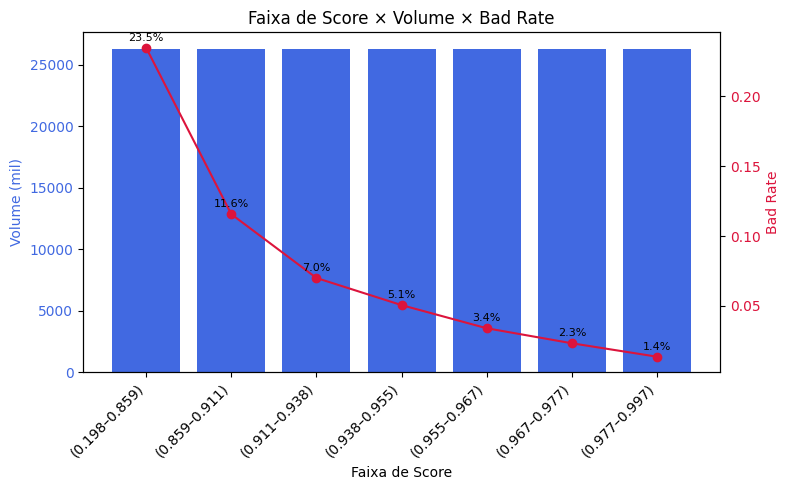

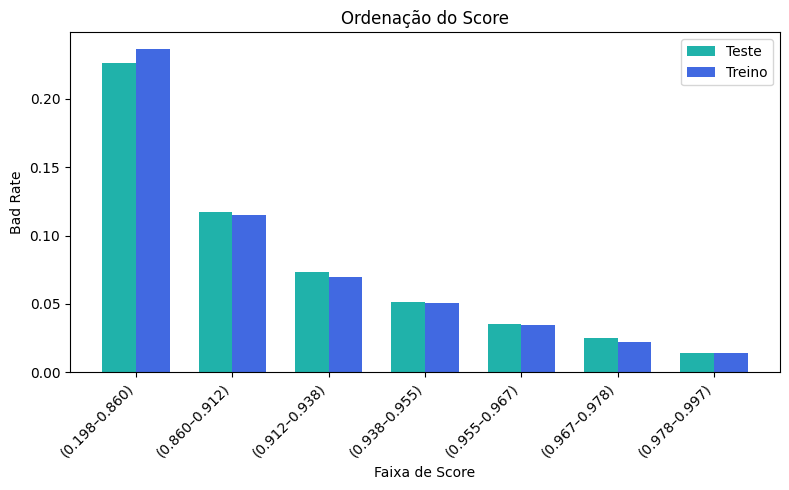

,Métrica,Treino,Teste,Geral
0,AUC,0.763017,0.755436,0.761494
1,Gini,0.526034,0.510873,0.522989
2,KS,0.396598,0.387197,0.394383


In [ ]:
metrics, tabela_treino, tabela_teste, tabela_geral = funcs_deriv.calculate_metrics_final(df_final)

metrics

In [ ]:
tabela_geral

,faixa_str,min_score,max_score,event_rate,volume,lim_inf
0,(0.977–0.997),0.977445,0.996867,0.013707,26336,0.977445
1,(0.967–0.977),0.966848,0.977444,0.023314,26336,0.966848
2,(0.955–0.967),0.954694,0.966848,0.034061,26335,0.954694
3,(0.938–0.955),0.937588,0.954694,0.050615,26336,0.937588
4,(0.911–0.938),0.911349,0.937587,0.070021,26335,0.911349
5,(0.859–0.911),0.859137,0.911347,0.115659,26336,0.859137
6,(0.198–0.859),0.199210,0.859137,0.234698,26336,0.199210


In [ ]:
tabela_treino

,faixa_str,min_score,max_score,event_rate,volume,lim_inf
0,(0.978–0.997),0.977791,0.996867,0.013954,21069,0.977791
1,(0.967–0.978),0.967353,0.977790,0.022356,21068,0.967353
2,(0.955–0.967),0.955293,0.967353,0.034506,21069,0.955293
3,(0.938–0.955),0.938228,0.955293,0.050361,21068,0.938228
4,(0.912–0.938),0.912224,0.938228,0.069391,21069,0.912224
5,(0.860–0.912),0.860135,0.912222,0.114676,21068,0.860135
6,(0.198–0.860),0.199210,0.860132,0.236841,21069,0.199210


In [ ]:
tabela_teste

,faixa_str,min_score,max_score,event_rate,volume,lim_inf
0,(0.976–0.996),0.975876,0.995969,0.013670,5267,0.975876
1,(0.965–0.976),0.964690,0.975875,0.024872,5267,0.964690
2,(0.952–0.965),0.952231,0.964688,0.035124,5267,0.952231
3,(0.935–0.952),0.934898,0.952227,0.051073,5267,0.934898
4,(0.908–0.935),0.907991,0.934890,0.073476,5267,0.907991
5,(0.855–0.908),0.855080,0.907991,0.117524,5267,0.855080
6,(0.247–0.855),0.247882,0.855073,0.226272,5268,0.247882


## 09. Shap Value

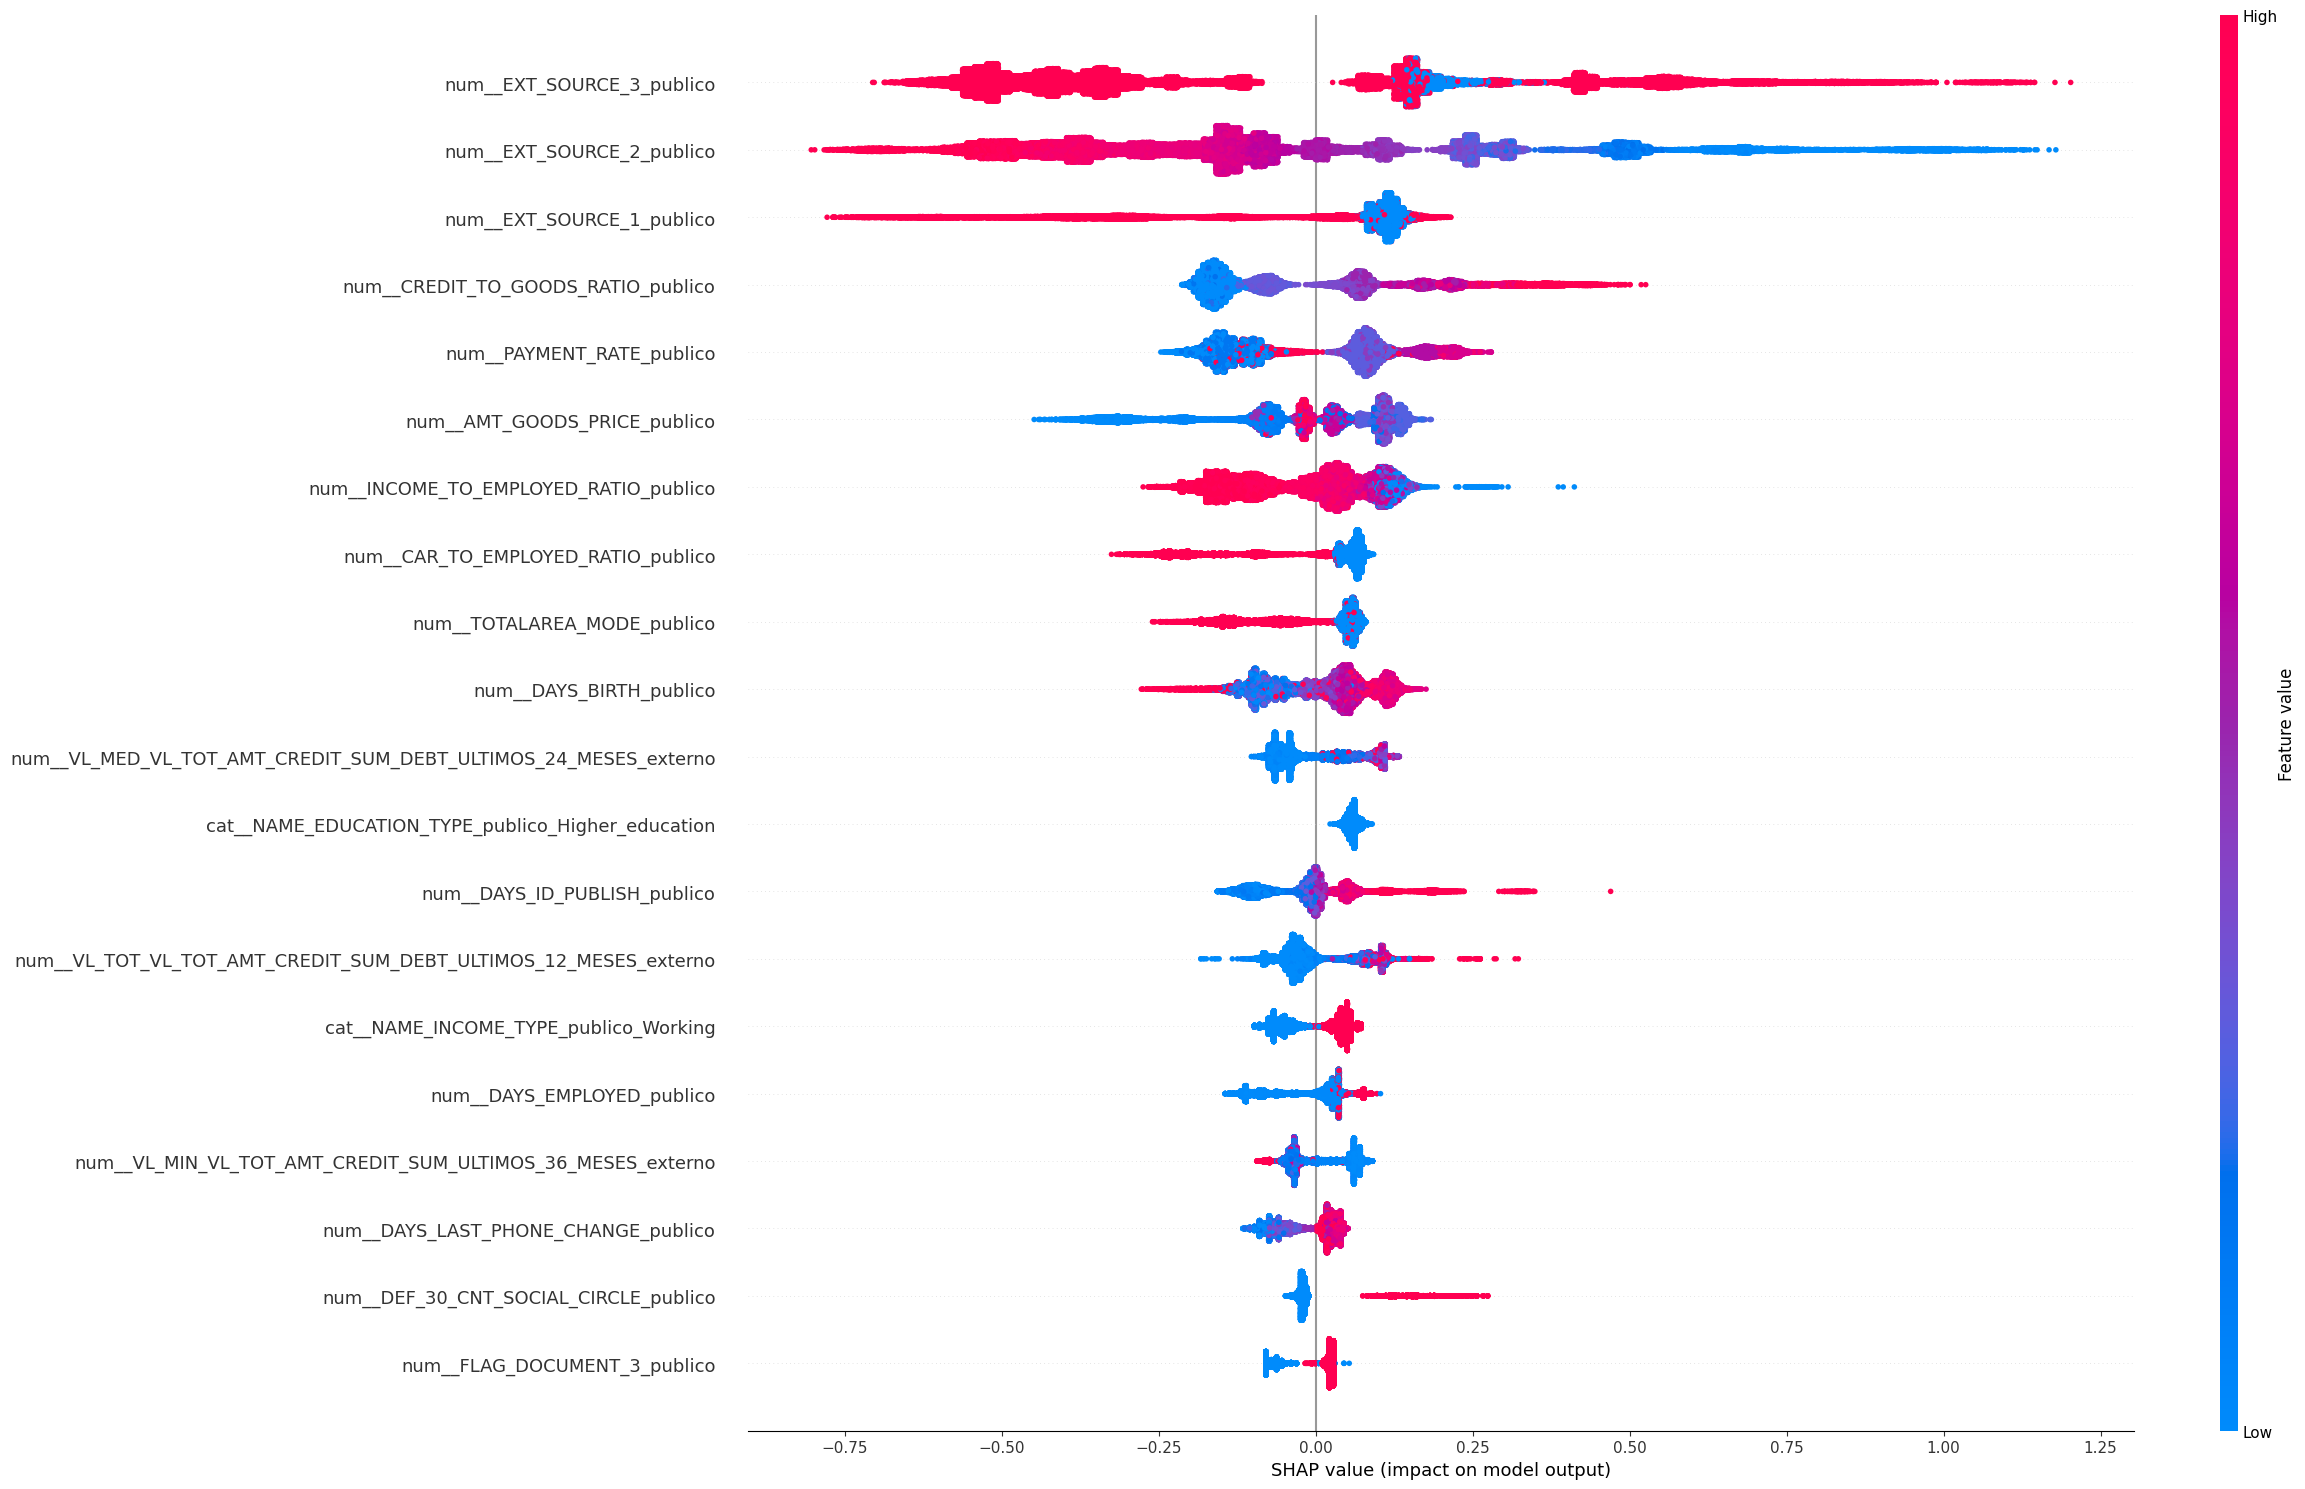

In [ ]:
# Shap values: variáveis por ordem de entrada
X_teste_final = df_final[df_final['periodo'] == 'teste'][variaveis_finais]

# Usar TreeExplainer com XGBoost é o mais rápido
explainer = shap.TreeExplainer(model)

# Calcular os valores SHAP (não sobrescreva!)
shap_values = explainer.shap_values(X_teste_final)

# Gerar gráfico de resumo (summary plot)
shap.summary_plot(shap_values, X_teste_final, plot_size=(25, 15))  #(12,10)

## 10. Salvando a base do modelo

In [ ]:
df_final.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,num__EXT_SOURCE_1_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__FLAG_DOCUMENT_3_publico,...,num__INCOME_TO_BIRTH_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo,num__DAYS_LAST_PHONE_CHANGE_publico,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo,num__REGION_POPULATION_RELATIVE_publico,periodo,score,prob0,prob1,predito
0,100010,0,0.540654,0.714279,-999.0,1.00,-999.0,-999.000000,-801.780029,1.0,...,-19.10,-999.0,-1070.0,-999.0,0.003122,treino,976,0.975734,0.024266,0
1,100263,0,0.270707,0.235314,0.0,1.00,0.0,0.770814,0.300000,1.0,...,-4.60,0.0,-2255.0,165240.0,0.009549,treino,932,0.931950,0.068050,0
2,100320,0,-999.000000,0.610447,44203.5,1.04,-999.0,-999.000000,-77.400002,1.0,...,-18.76,-999.0,-842.0,1068750.0,0.025164,treino,933,0.933352,0.066648,0
3,100704,0,0.621226,0.398296,-999.0,1.00,-999.0,0.676170,-12.780000,1.0,...,-5.06,0.0,-196.0,135000.0,0.028663,treino,975,0.975144,0.024856,0
4,100768,0,0.556727,0.639849,-999.0,1.21,-999.0,0.722559,-49.540001,1.0,...,-5.50,-999.0,-1643.0,252000.0,0.009175,treino,969,0.969003,0.030997,0


In [ ]:
## Salvar a base de teste em parquet
df_final.to_parquet(r'D:\projeto_modelo_credito\dados\df_final_modelo_xgboost.parquet', engine='pyarrow', index=False)

In [ ]:
# Baixando a base final salva
df_xgb = pd.read_parquet(r'D:\projeto_modelo_credito\dados\df_final_modelo_xgboost.parquet',
                                 engine='pyarrow')
df_xgb.head()

,SK_ID_CURR,TARGET,num__EXT_SOURCE_3_publico,num__EXT_SOURCE_2_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_24_MESES_externo,num__CREDIT_TO_GOODS_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_MAX_OVERDUE_ULTIMOS_12_MESES_externo,num__EXT_SOURCE_1_publico,num__INCOME_TO_EMPLOYED_RATIO_publico,num__FLAG_DOCUMENT_3_publico,...,num__INCOME_TO_BIRTH_RATIO_publico,num__VL_TOT_VL_TOT_AMT_CREDIT_SUM_LIMIT_ULTIMOS_24_MESES_externo,num__DAYS_LAST_PHONE_CHANGE_publico,num__VL_MIN_VL_TOT_AMT_CREDIT_SUM_ULTIMOS_36_MESES_externo,num__REGION_POPULATION_RELATIVE_publico,periodo,score,prob0,prob1,predito
0,100010,0,0.540654,0.714279,-999.0,1.00,-999.0,-999.000000,-801.780029,1.0,...,-19.10,-999.0,-1070.0,-999.0,0.003122,treino,976,0.975734,0.024266,0
1,100263,0,0.270707,0.235314,0.0,1.00,0.0,0.770814,0.300000,1.0,...,-4.60,0.0,-2255.0,165240.0,0.009549,treino,932,0.931950,0.068050,0
2,100320,0,-999.000000,0.610447,44203.5,1.04,-999.0,-999.000000,-77.400002,1.0,...,-18.76,-999.0,-842.0,1068750.0,0.025164,treino,933,0.933352,0.066648,0
3,100704,0,0.621226,0.398296,-999.0,1.00,-999.0,0.676170,-12.780000,1.0,...,-5.06,0.0,-196.0,135000.0,0.028663,treino,975,0.975144,0.024856,0
4,100768,0,0.556727,0.639849,-999.0,1.21,-999.0,0.722559,-49.540001,1.0,...,-5.50,-999.0,-1643.0,252000.0,0.009175,treino,969,0.969003,0.030997,0


## 11. Salvando o  modelo XGBoost em um pickle

In [ ]:
pickle.dump(model, open('modelo_xgboost_concessao.pkl', 'wb'))